### Lab 5
- Juan Pablo Solis
- Brandon Reyes
- Carlos Valladares

### Link de Video de Youtube
- https://youtu.be/GQlw5S1Lm_0

### Link de Repositorio de Github:
https://github.com/JPS4321/Lab5_IA

### Task 1.1 Discretizacion Imagen

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import label
from abc import ABC, abstractmethod
from collections import deque
from queue import PriorityQueue

In [6]:
def process_maze(image_path):
    image = Image.open(image_path).convert("RGB")
    image_array = np.array(image)
    height, width, _ = image_array.shape

    black_walls = (image_array[:, :, 0] < 50) & (image_array[:, :, 1] < 50) & (image_array[:, :, 2] < 50)
    red_start = (image_array[:, :, 0] > 200) & (image_array[:, :, 1] < 100) & (image_array[:, :, 2] < 100)
    green_goal = (image_array[:, :, 1] > 200) & (image_array[:, :, 0] < 100) & (image_array[:, :, 2] < 100)

    red_positions = np.where(red_start)
    if len(red_positions[0]) > 0:
        cell_size = max(red_positions[0].max() - red_positions[0].min(), red_positions[1].max() - red_positions[1].min())
    else:
        cell_size = 10

    grid_height = height // cell_size
    grid_width = width // cell_size
    grid = np.ones((grid_height, grid_width, 3), dtype=np.uint8) * 255  # Fondo blanco

    labeled_goals, num_goals = label(green_goal)
    goals = []
    for goal_id in range(1, num_goals + 1):
        goal_pixels = np.where(labeled_goals == goal_id)
        center_y = int(goal_pixels[0].mean()) // cell_size
        center_x = int(goal_pixels[1].mean()) // cell_size
        grid[center_y, center_x] = [0, 255, 0]  # Verde
        goals.append((center_y, center_x))

    start = None
    if len(red_positions[0]) > 0:
        red_cell_x = red_positions[1].min() // cell_size
        red_cell_y = red_positions[0].min() // cell_size
        grid[red_cell_y, red_cell_x] = [255, 0, 0]  # Rojo
        start = (red_cell_y, red_cell_x)

    for i in range(grid_height):
        for j in range(grid_width):
            block = image_array[i * cell_size:(i + 1) * cell_size, j * cell_size:(j + 1) * cell_size]
            avg_color = block.mean(axis=(0, 1))
            if avg_color[0] < 50 and avg_color[1] < 50 and avg_color[2] < 50:
                grid[i, j] = [0, 0, 0]  # Pared negra

    return grid, start, goals

### Task 1.2 Framework de problemas

In [7]:
class MazeProblem(ABC):
    def __init__(self, grid):
        self.grid = grid

    @abstractmethod
    def actions(self, state):
        pass

    @abstractmethod
    def step_cost(self, state, action, next_state):
        pass

    @abstractmethod
    def is_goal(self, state):
        pass

class ConcreteMazeProblem(MazeProblem):
    def __init__(self, grid, start, goals):
        super().__init__(grid)
        self.start = start
        self.goals = goals

    def actions(self, state):
        moves = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        valid_moves = []
        for move in moves:
            new_state = (state[0] + move[0], state[1] + move[1])
            if 0 <= new_state[0] < self.grid.shape[0] and 0 <= new_state[1] < self.grid.shape[1] and not np.array_equal(self.grid[new_state[0], new_state[1]], [0, 0, 0]):
                valid_moves.append(move)
        return valid_moves

    def step_cost(self, state, action, next_state):
        return 1

    def is_goal(self, state):
        return state in self.goals

### Task 1.3 y 1.4: Graph-Search y construccion de salida

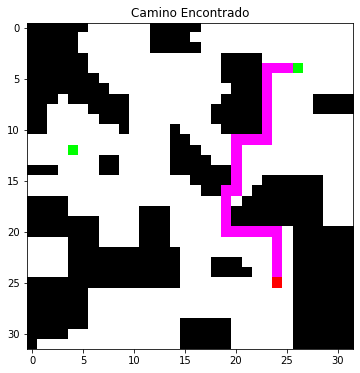

In [8]:
def reconstruct_path(came_from, current):
    path = []
    while current is not None:
        path.append(current)
        current = came_from[current]
    path.reverse()
    return path

def bfs(problem):
    frontier = deque([problem.start])
    came_from = {problem.start: None}
    while frontier:
        current = frontier.popleft()
        if problem.is_goal(current):
            return reconstruct_path(came_from, current)
        for action in problem.actions(current):
            next_state = (current[0] + action[0], current[1] + action[1])
            if next_state not in came_from:
                frontier.append(next_state)
                came_from[next_state] = current
    return None

def dfs(problem):
    stack = [(problem.start, [])]
    visited = set()
    while stack:
        current, path = stack.pop()
        if current in visited:
            continue
        visited.add(current)
        if problem.is_goal(current):
            return path + [current]
        for action in problem.actions(current):
            next_state = (current[0] + action[0], current[1] + action[1])
            stack.append((next_state, path + [current]))
    return None

def heuristic_manhattan(state, goals):
    return min(abs(state[0] - g[0]) + abs(state[1] - g[1]) for g in goals)

def heuristic_euclidean(state, goals):
    return min(((state[0] - g[0]) ** 2 + (state[1] - g[1]) ** 2) ** 0.5 for g in goals)

def plot_path(grid, path):
    grid_image = np.copy(grid)
    for y, x in path:
        if not np.array_equal(grid_image[y, x], [255, 0, 0]) and not np.array_equal(grid_image[y, x], [0, 255, 0]):
            grid_image[y, x] = [255, 0, 255]  # Magenta
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(grid_image)
    ax.set_title("Camino Encontrado")
    plt.show()

test_image_path = "Test.bmp"
grid, start, goals = process_maze(test_image_path)
problem = ConcreteMazeProblem(grid, start, goals)
path = bfs(problem)
if path:
    plot_path(grid, path)
